<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/Time_Series_Forecasting_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not a financial advice.

Links:
* [github-notes](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb)
* [Uber Forecast Blog](https://www.uber.com/en-IN/blog/forecasting-introduction/)

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: [Market-Watch](https://www.marketwatch.com/investing/cryptocurrency/btcusd/download-data#:~:text=Download%20CoinDesk%20Bitcoin%20Price%20Index%20(XBX)%20stock%20data:%20historical%20BTCUSD%20stock%20prices%20from%20MarketWatch.)

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-04-25 11:51:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.005s  

2024-04-25 11:51:28 (32.2 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'], index_col=['Date'])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.sort_index(inplace=True)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~1 year but there's 367 sampels.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples.

In [8]:
# remove commas from df and convert objects into float numbers
df.replace(',', '', regex=True, inplace=True)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


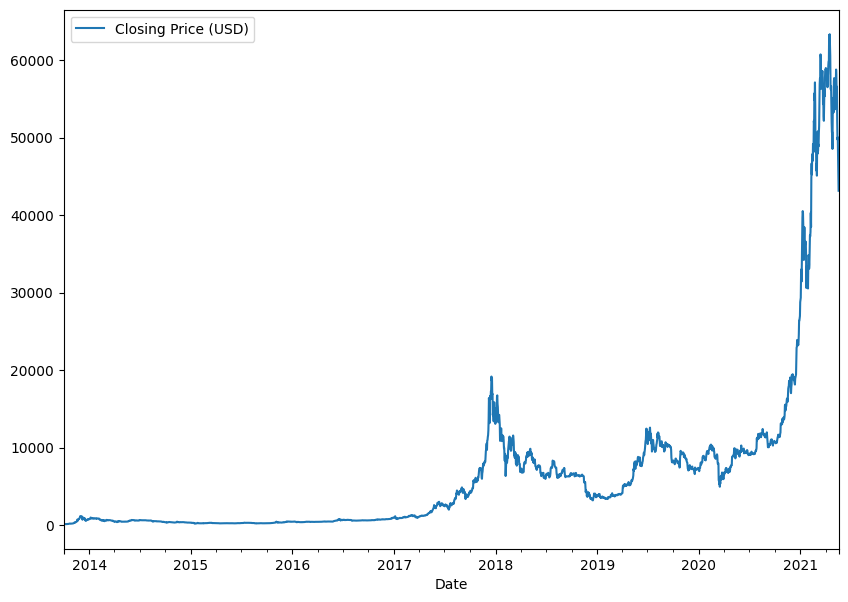

In [11]:
# plot Month Vs Closing Price
df.plot(y='Closing Price (USD)', figsize=(10, 7))
plt.show()

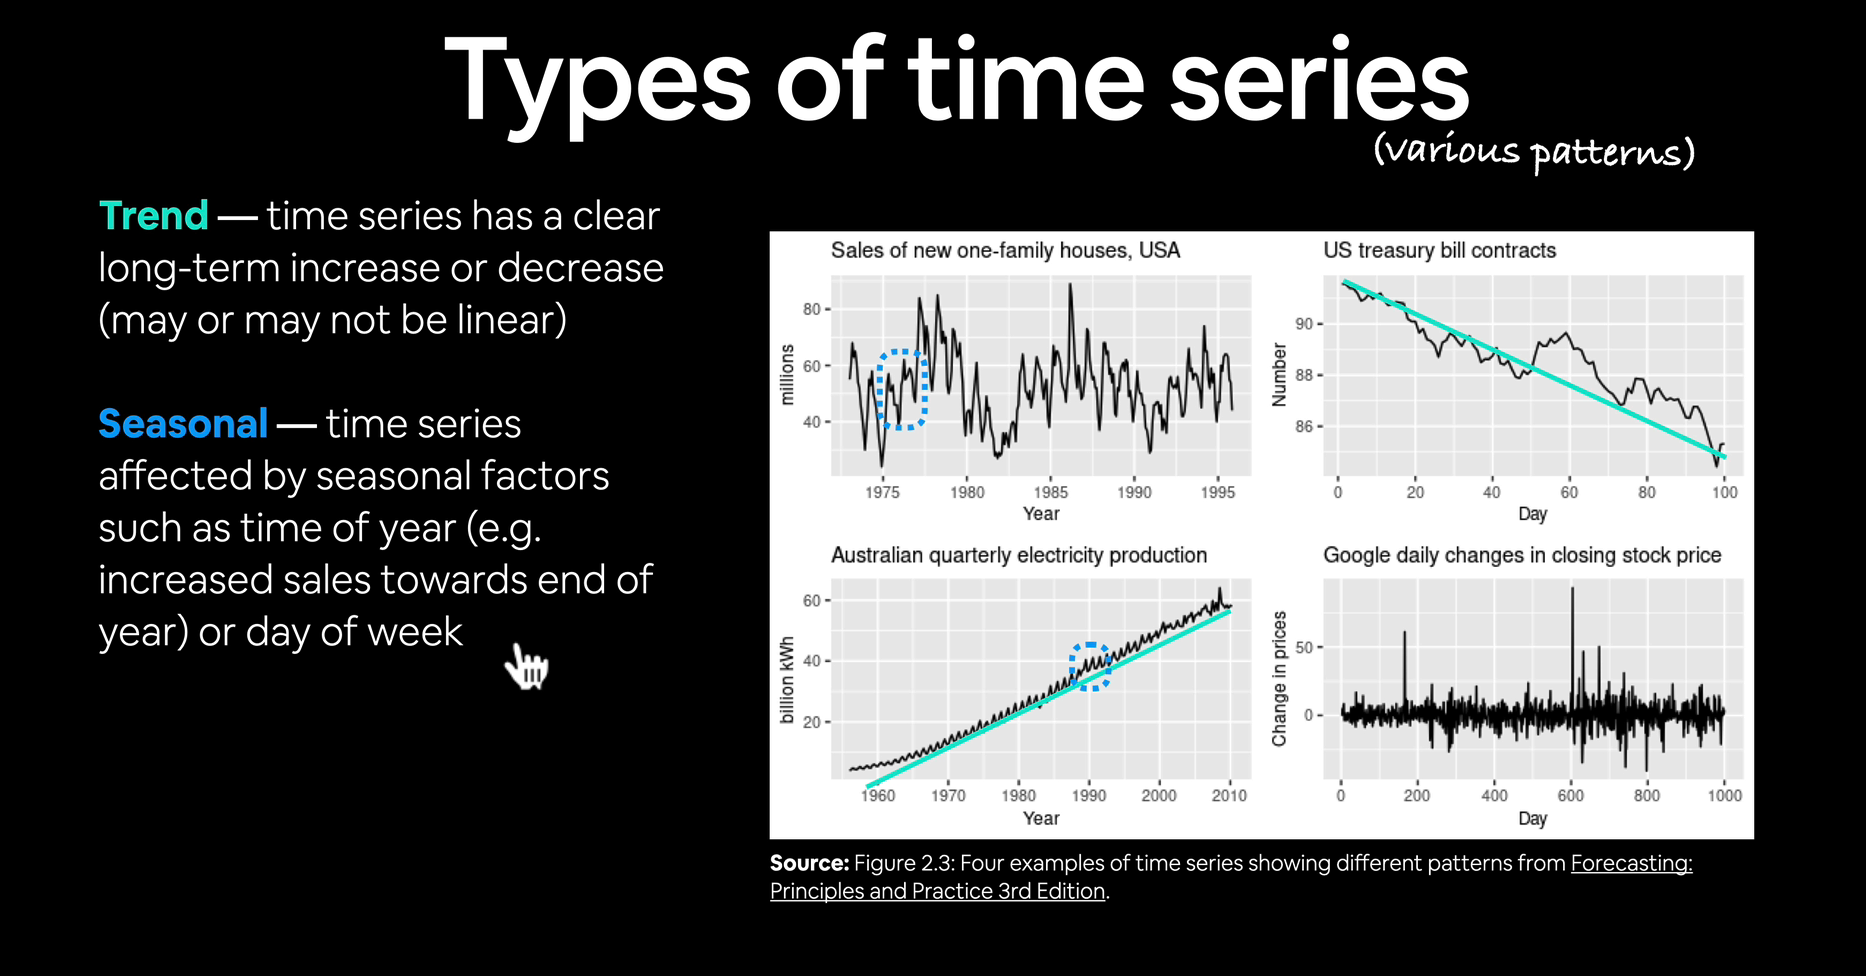

In [12]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [19]:
bitcoin_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


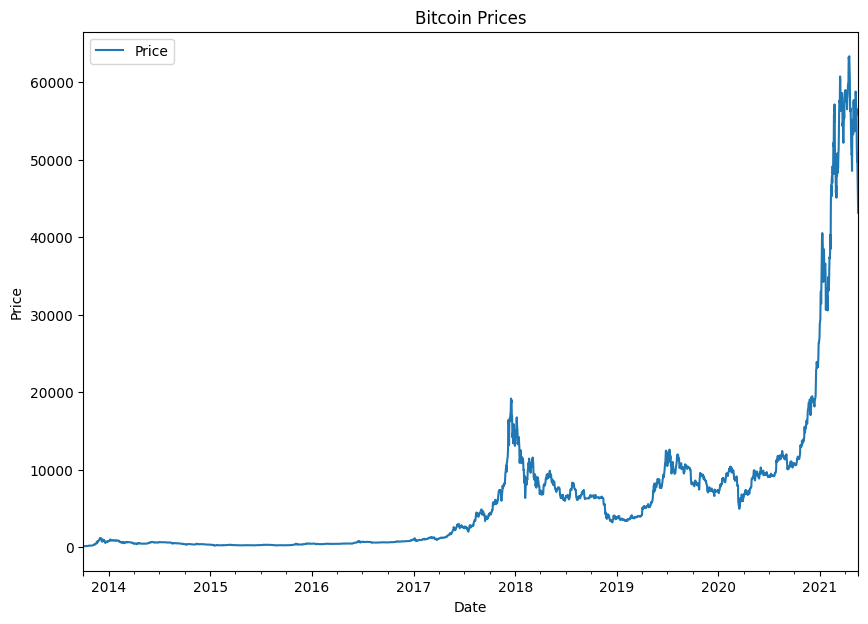

In [13]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('Price')
plt.title('Bitcoin Prices')
plt.show()

## Importing time series data with python's CSV module

In [23]:
# Importin and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
    csvreader = csv.reader(f, delimiter=',')
    next(csvreader) # Skip the header
    for row in csvreader:
        timesteps.append(datetime.strptime(row[1], '%Y-%m-%d'))
        btc_price.append(float(row[2].replace(',', '')))

timesteps[:5], btc_price[:5]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0)],
 [123.65499, 125.455, 108.58483, 118.67466, 121.33866])

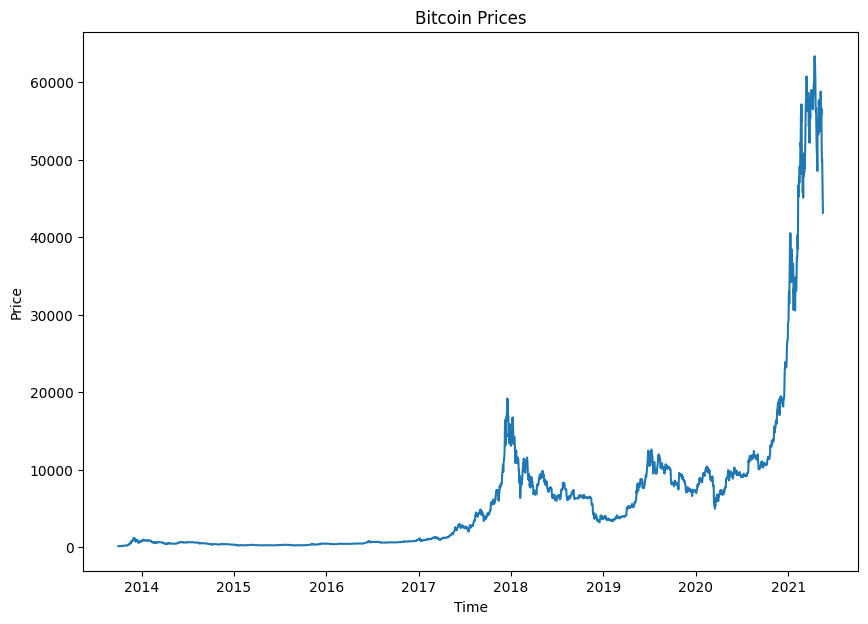

In [24]:
# Plot from CSV
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Prices')
plt.show()

## Create train and test sets of our time series data

### Creating train and test sets with time series data (WRONG WAY)

In [25]:
# Using scikit learn train_test_split
from sklearn.model_selection import train_test_split

# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

# Split into train and test sets (wrong way)
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices,
                                                    test_size=0.15, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2368,), (419,), (2368,), (419,))

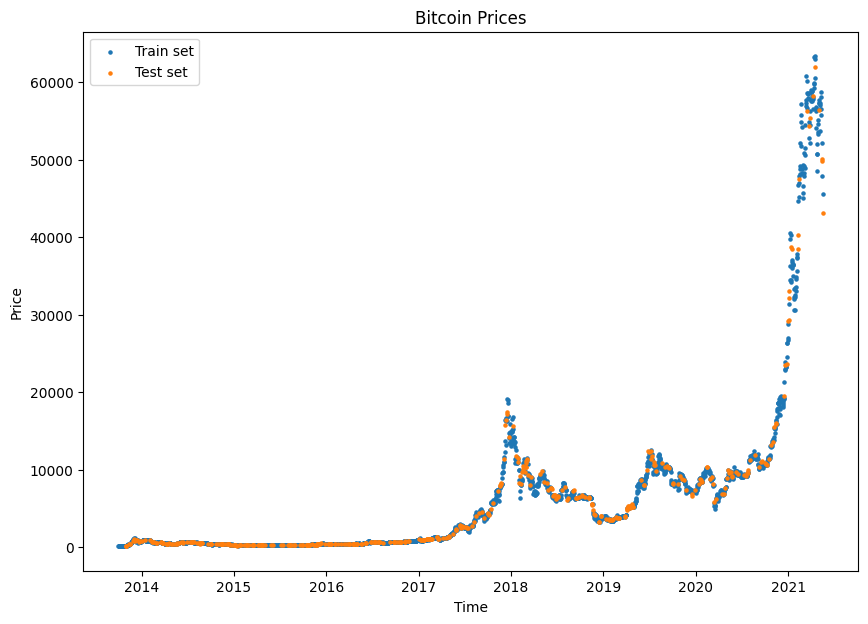

In [26]:
# Let's splot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train set')
plt.scatter(X_test, y_test, s=5, label='Test set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Prices')
plt.legend()
plt.show()

### Creating train and test sets with time series data (RIGHT WAY)

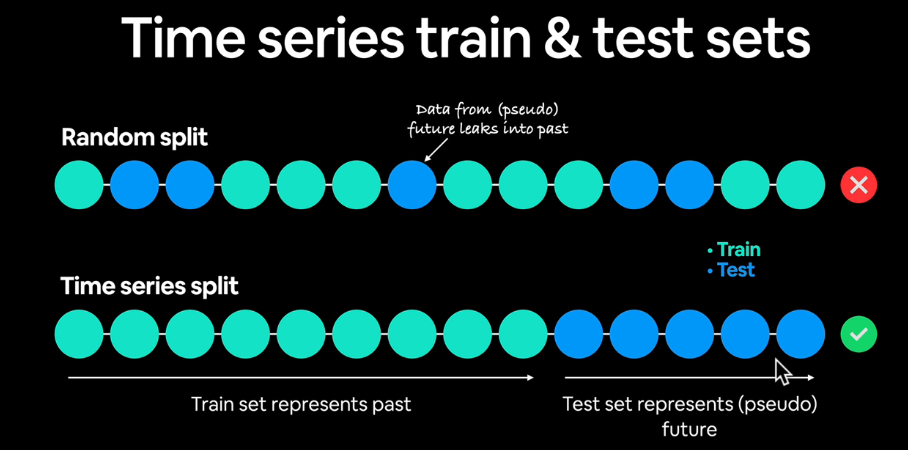

In [27]:
# Create train and test splits the right way
split_size = int(0.80 * len(prices)) # 80% of the train data, and 15% of the test data

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

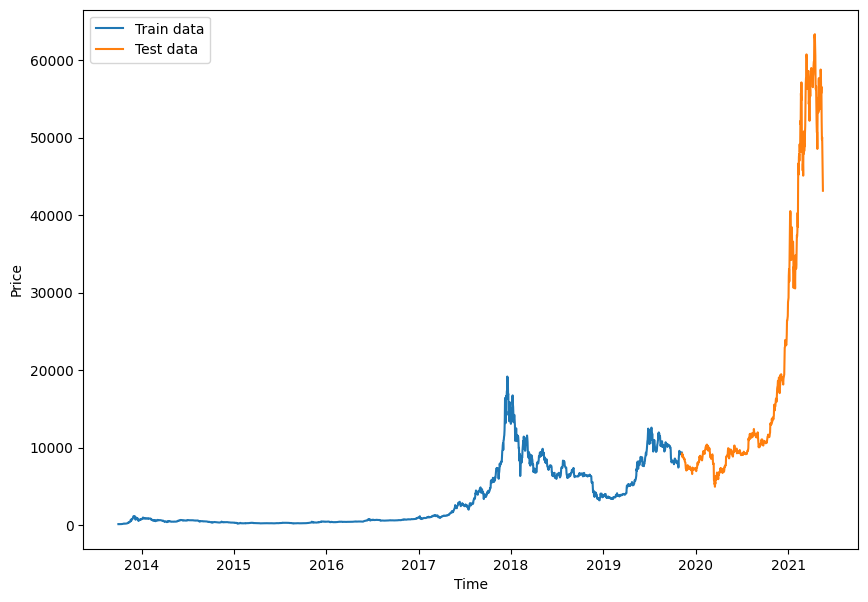

In [28]:
# Plot the correct split
plt.figure(figsize=(10, 7))
plt.plot(timesteps[:split_size], prices[:split_size], label="Train data")
plt.plot(timesteps[split_size:], prices[split_size:], label="Test data")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Create a plotting function

Typing plotting code is tedious, so let's create a function for it.

In [29]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  '''
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values
  label : label to show on plot of values
  '''
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end],
           format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=14) # Make label bigger
  plt.grid(True)

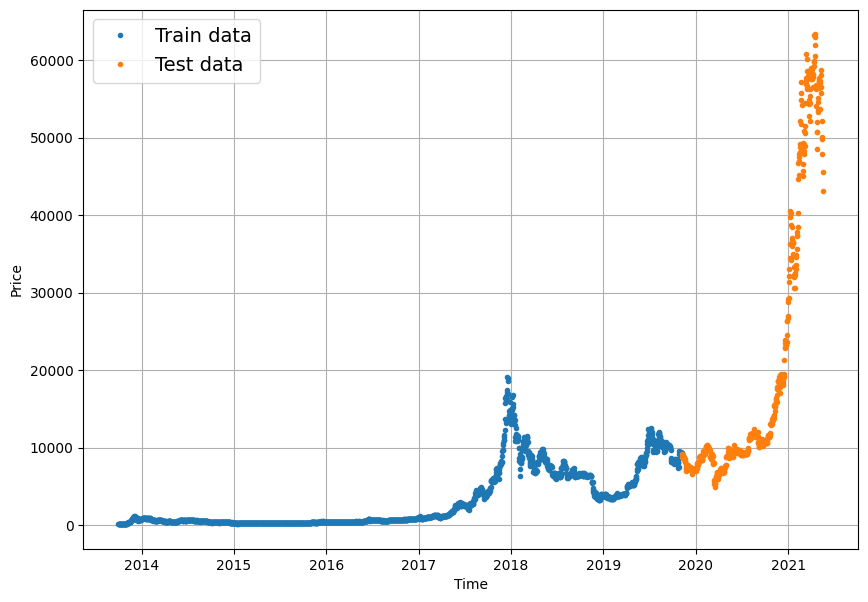

In [30]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict.
* **Window size** = number of timesteps we're going to use to predict **horizon**

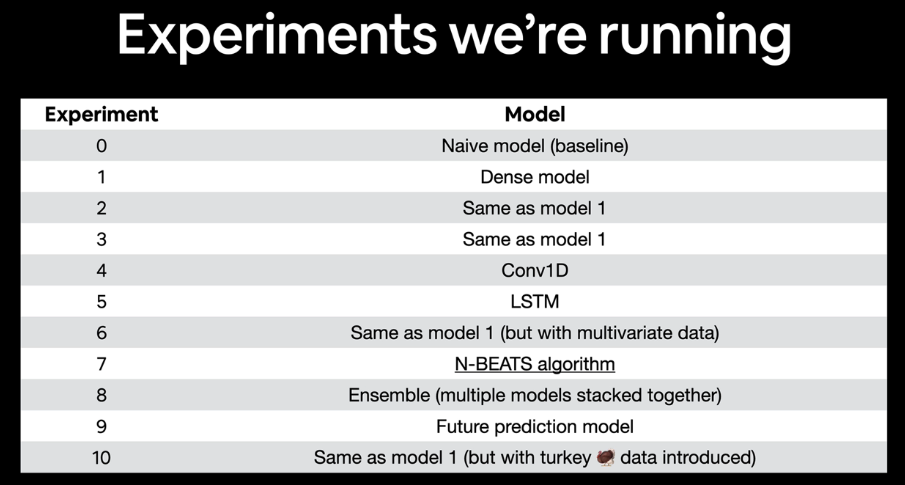

### Model 0: Naive model (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep t (y-hat) is equal to value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [31]:
# Create a navie forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [32]:
len(naive_forecast), len(y_test)

(557, 558)

In [33]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

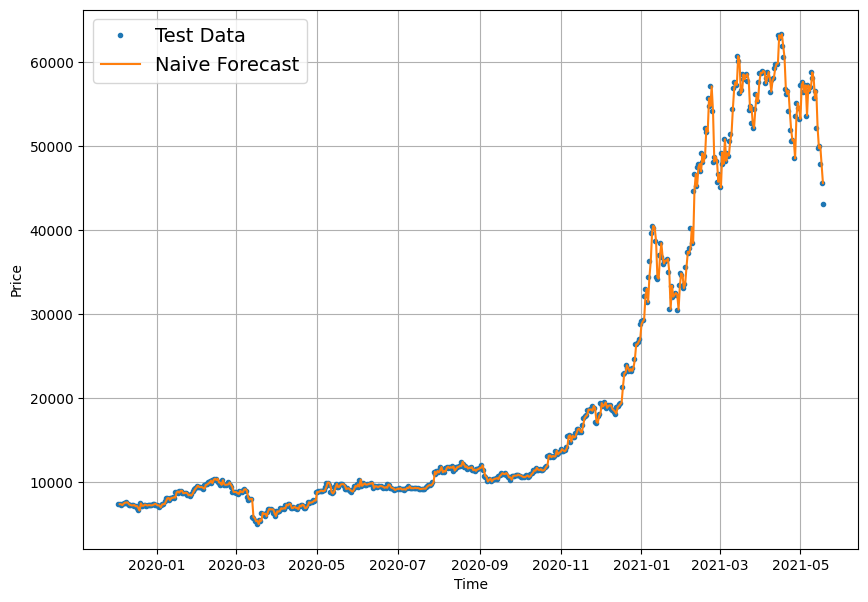

In [34]:
# Plot the naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label='Train Data')
plot_time_series(timesteps=X_test, values=y_test, start=25, label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', start=25, label='Naive Forecast')

📃**Resource:** [Naive Forecast](https://otexts.com/fpp2/simple-methods.html)

Try to find why Naive's forecast is hard to beat.

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regreession problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, lower is better, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

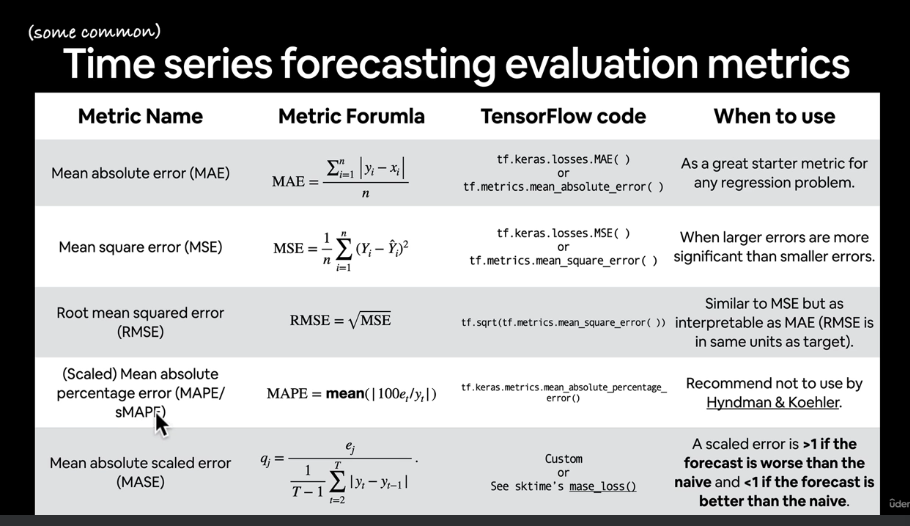

In [35]:
import tensorflow as tf

# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  '''
  Implement MASE (assuming no seasonality of data)
  y_true: true values
  y_pred: predicted values
  '''
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [36]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [119]:
# Let's write a function that returns different metrics of errors
def reg_metrics(y_true, y_pred):
  '''
  Returns MAE, MSE, RMSE, MAPE, MASE in a dict format.
  y_true: true values
  y_pred: predicted values
  '''
  # MAE
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)

  # MSE
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)

  # RMSE
  rmse = tf.sqrt(mse)

  # MAPE
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)  # # Find MAE of naive forecast (no seasonality)

  # MASE
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  metrics = {
      'Mean Absolute Error': mae.numpy(),
      'Mean Squared Error': mse.numpy(),
      'Root Mean Squared Error': rmse.numpy(),
      'Mean Absolute Percentage Error': mape.numpy(),
      'Mean Absolute Scaled Error': mase.numpy()
  }

  return metrics

That's one good looking evaluation function!

Let's now see if it works...

In [38]:
naive_results = reg_metrics(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'Mean Absolute Error': 567.9802273457541,
 'Mean Squared Error': 1147547.125023896,
 'Root Mean Squared Error': 1071.2362601330744,
 'Mean Absolute Percentage Error': 2.516524929982267,
 'Mean Absolute Scaled Error': 0.9995699939182624}

In [40]:
y_test[:20]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 , 8537.33965197, 8205.80636599,
       8118.4885358 , 8074.84317361, 7612.7405735 , 7262.11053495,
       7303.40575852, 7041.73293642, 7211.86180875, 7141.06944869])

In [41]:
naive_forecast[:20]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 , 8537.33965197, 8205.80636599,
       8118.4885358 , 8074.84317361, 7612.7405735 , 7262.11053495,
       7303.40575852, 7041.73293642, 7211.86180875, 7141.06944869])

In [42]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [43]:
# Max and min
tf.reduce_max(y_test), tf.reduce_min(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>,
 <tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>)

## Other models you can use for baseline and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/

## Format Data Part 2: Windowing our Dataset

Why do we window?

We window our time series dataset to turn data into suprvised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [44]:
btc_price[:10]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116]

In [45]:
# What we want to do with our Bitcoin data
print(f'We want to use: {btc_price[:7]} to predict: {btc_price[7]}')

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict: 123.033


In [46]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use past 7 days to predict next day

In [47]:
# Create function to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  '''
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7]
  Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  '''
  return x[:, :-horizon], x[:, -horizon:]

In [48]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8) + 1, axis=0))
print(f'Window: {test_window[:5].numpy()} -> Label: {test_label[:5].numpy()}')

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


We've got a way to label our windowed data.

However, this only works on a small scale.

We need to perform this across our whole time series data.

We could do this with Python for loops, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

> 📃**Resources:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [49]:
# Using loops
start = 0
end = start + WINDOW_SIZE
data = []
while end != len(btc_price) + 1:
  btc_window, btc_label = get_labelled_window(tf.expand_dims(btc_price[start:end], axis=0))
  data.append((btc_window.numpy(), btc_label.numpy()))
  start += 1
  end += 1

data[-5:]

[(array([[57107.12 , 58788.21 , 58102.19 , 55715.547, 56573.555, 52147.82 ]],
        dtype=float32),
  array([[49764.133]], dtype=float32)),
 (array([[58788.21 , 58102.19 , 55715.547, 56573.555, 52147.82 , 49764.133]],
        dtype=float32),
  array([[50032.69]], dtype=float32)),
 (array([[58102.19 , 55715.547, 56573.555, 52147.82 , 49764.133, 50032.69 ]],
        dtype=float32),
  array([[47885.625]], dtype=float32)),
 (array([[55715.547, 56573.555, 52147.82 , 49764.133, 50032.69 , 47885.625]],
        dtype=float32),
  array([[45604.617]], dtype=float32)),
 (array([[56573.555, 52147.82 , 49764.133, 50032.69 , 47885.625, 45604.617]],
        dtype=float32),
  array([[43144.473]], dtype=float32))]

In [50]:
import numpy as np

# Create a function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  '''
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  '''
  # 1. Create a window of specific window_size (add the extra dimension)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
  print(f'Window indices: \n{window_indexes, window_indexes.shape}')

  # # 3. Index on the target array (btc_price) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  print(f'WIndowed ARray: \n{windowed_array}')

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

In [51]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window indices: 
(array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]]), (2780, 8))
WIndowed ARray: 
[[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55715.54665129 ... 49764.1320816
  50032.69313676 47885.62525472]
 [58102.19142623 55715.54665129 56573.5554719  ... 50032.69313676
  47885.62525472 45604.61575361]
 [55715.54665129 56573.5554719  52147.82118698 ... 47885.62525472
  45604.61575361 43144.47129086]]


(2780, 2780)

In [53]:
# View the first/last 3 windoes/labels
for i in range(3):
  print(f'Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}')

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [54]:
prices[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

In [55]:
np.expand_dims(np.arange(8), 0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [56]:
full_windows

array([[  123.65499   ,   125.455     ,   108.58483   , ...,
          121.33866   ,   120.65533   ,   121.795     ],
       [  125.455     ,   108.58483   ,   118.67466   , ...,
          120.65533   ,   121.795     ,   123.033     ],
       [  108.58483   ,   118.67466   ,   121.33866   , ...,
          121.795     ,   123.033     ,   124.049     ],
       ...,
       [58788.20967893, 58102.19142623, 55715.54665129, ...,
        52147.82118698, 49764.1320816 , 50032.69313676],
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361]])

🔑**Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

In [57]:
# Let's try with tensorflow
tf_window_data = tf.keras.preprocessing.timeseries_dataset_from_array(
    prices,
    prices[WINDOW_SIZE:],
    sequence_length=WINDOW_SIZE,
    sequence_stride=1,
    shuffle=False,
    batch_size=1
)

In [59]:
for window, label in tf_window_data.take(3):
  print(f'Window: {window.numpy()} -> Label: {label.numpy()}')

Window: [[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]] -> Label: [123.033]
Window: [[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]] -> Label: [124.049]
Window: [[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]] -> Label: [125.96116]


## Turning windowed data into training and test sets

In [60]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  '''
  Splits matching pairs of windows and labels into train and test splits.
  '''
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, train_labels, test_windows, test_labels

In [61]:
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we'training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [62]:
import os

# Create a function a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)


## Model 1: Dense Model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU activation
* An output layer with linear activation (no activation function)
* Adam optimization and MAE loss function
* Batch size of 32
* 30 epochs

Why these values?
Probably not, for that hyperparameter tuning is required.

* **Hyperparameters** = values of a machine learning practioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [63]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing

# Build the model
inputs = layers.Input(shape=(WINDOW_SIZE,), name='input_layer')
x = layers.Dense(128, activation='relu')(inputs)
outputs = layers.Dense(HORIZON, activation='linear')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

# Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Get the summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Fit the model
model_1_history = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=60,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/60
18/18 [==============================] - 2s 79ms/step - loss: 1713.2999 - mae: 1713.2999 - mse: 9291851.0000 - val_loss: 1431.6143 - val_mae: 1431.6143 - val_mse: 6547004.0000
Epoch 2/60
18/18 [==============================] - 0s 8ms/step - loss: 355.2997 - mae: 355.2997 - mse: 506181.7500 - val_loss: 1996.0630 - val_mae: 1996.0630 - val_mse: 9763531.0000
Epoch 3/60
18/18 [==============================] - 1s 36ms/step - loss: 263.6341 - mae: 263.6341 - mse: 328022.1875 - val_loss: 1365.7954 - val_mae: 1365.7954 - val_mse: 5623640.5000
Epoch 4/60
18/18 [==============================] - 1s 30ms/step - loss: 229.1491 - mae: 229.1491 - mse: 263766.7188 - val_loss: 1291.0741 - val_mae: 1291.0741 - val_mse: 5172365.5000
Epoch 5/60
18/18 [==============================] - 1s 29ms/step - loss: 216.5121 - mae: 216.5121 - mse: 242321.3750 - val_loss: 1193.7365 - val_mae: 1193.7365 - val_mse: 4543365.5000
Epoch 6/60
18/18 [==============================] - 1s 32ms/step - loss: 206.8

In [65]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.3843 - mae: 608.3843 - mse: 1280239.6250


[608.3843383789062, 608.3843383789062, 1280239.625]

In [66]:
# Load in save best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 600.2990 - mae: 600.2990 - mse: 1276437.1250


[600.2990112304688, 600.2990112304688, 1276437.125]

In [67]:
naive_results

{'Mean Absolute Error': 567.9802273457541,
 'Mean Squared Error': 1147547.125023896,
 'Root Mean Squared Error': 1071.2362601330744,
 'Mean Absolute Percentage Error': 2.516524929982267,
 'Mean Absolute Scaled Error': 0.9995699939182624}

## Making forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's predict() method
4. Returns the predictions

In [68]:
def make_preds(model, input_data):
  '''
  Uses model to make predictions on input_data.
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1-dim array (remove dimension of size 1)


In [69]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8950.578, 8799.995, 8947.491, 8808.553, 8768.32 , 8769.326,
        8648.98 , 8592.115, 8467.176, 8503.856], dtype=float32)>)

In [70]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [71]:
# Evaluate preds
model_1_results = reg_metrics(y_true=np.squeeze(test_labels),
                             y_pred=model_1_preds.numpy())
model_1_results

{'Mean Absolute Error': 600.2990378759375,
 'Mean Squared Error': 1276437.4645822125,
 'Root Mean Squared Error': 1129.7953197735476,
 'Mean Absolute Percentage Error': 2.69108,
 'Mean Absolute Scaled Error': 1.0545590318431366}

In [72]:
naive_results

{'Mean Absolute Error': 567.9802273457541,
 'Mean Squared Error': 1147547.125023896,
 'Root Mean Squared Error': 1071.2362601330744,
 'Mean Absolute Percentage Error': 2.516524929982267,
 'Mean Absolute Scaled Error': 0.9995699939182624}

In [73]:
test_labels[:10, 0]

array([8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
       8749.52059102, 8656.97092235, 8500.64355816, 8469.2608989 ,
       8537.33965197, 8205.80636599])

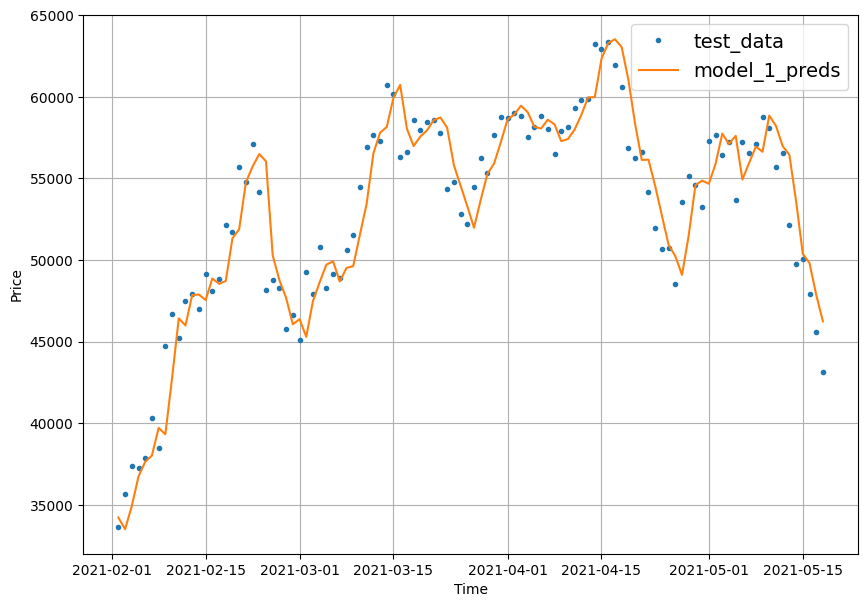

In [76]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format='-',
                 label='model_1_preds')

## Model 2: Dense Model (window size = 30, horizon = 1)

In [77]:
# create data with window size 30 and horizon 7
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(prices,
                                            window_size=WINDOW_SIZE,
                                            horizon=HORIZON)

Window indices: 
(array([[   0,    1,    2, ...,   28,   29,   30],
       [   1,    2,    3, ...,   29,   30,   31],
       [   2,    3,    4, ...,   30,   31,   32],
       ...,
       [2754, 2755, 2756, ..., 2782, 2783, 2784],
       [2755, 2756, 2757, ..., 2783, 2784, 2785],
       [2756, 2757, 2758, ..., 2784, 2785, 2786]]), (2757, 31))
WIndowed ARray: 
[[  123.65499      125.455        108.58483    ...   192.75666
    197.4          196.02499   ]
 [  125.455        108.58483      118.67466    ...   197.4
    196.02499      198.04883   ]
 [  108.58483      118.67466      121.33866    ...   196.02499
    198.04883      198.93233   ]
 ...
 [63346.78903511 61965.7825981  60574.44472823 ... 49764.1320816
  50032.69313676 47885.62525472]
 [61965.7825981  60574.44472823 56850.83016569 ... 50032.69313676
  47885.62525472 45604.61575361]
 [60574.44472823 56850.83016569 56224.10158771 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [78]:
full_windows.shape, full_labels.shape

((2757, 30), (2757, 1))

In [79]:
full_windows[0], full_labels[0]

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
        126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
        152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
        180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ]),
 array([196.02499]))

In [82]:
# Make train and testing windows
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows,
                                                                               full_labels,
                                                                               test_split=0.2)

In [83]:
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [84]:
# Create a Sequential Model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit the model
model_2_history = model_2.fit(x=train_windows,
                              y=train_labels,
                              epochs=60,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/60
18/18 [==============================] - 1s 40ms/step - loss: 411.3220 - mae: 411.3220 - mse: 714039.4375 - val_loss: 1415.3035 - val_mae: 1415.3035 - val_mse: 5851203.5000
Epoch 2/60
18/18 [==============================] - 1s 30ms/step - loss: 234.1546 - mae: 234.1546 - mse: 268858.3438 - val_loss: 1187.9688 - val_mae: 1187.9688 - val_mse: 4584385.5000
Epoch 3/60
18/18 [==============================] - 0s 29ms/step - loss: 206.3692 - mae: 206.3692 - mse: 213008.7188 - val_loss: 1090.8613 - val_mae: 1090.8613 - val_mse: 3800366.7500
Epoch 4/60
18/18 [==============================] - 1s 45ms/step - loss: 189.5366 - mae: 189.5366 - mse: 177285.4844 - val_loss: 1008.2573 - val_mae: 1008.2573 - val_mse: 3335425.2500
Epoch 5/60
18/18 [==============================] - 0s 6ms/step - loss: 184.8833 - mae: 184.8833 - mse: 166683.5625 - val_loss: 1370.3518 - val_mae: 1370.3518 - val_mse: 5581920.0000
Epoch 6/60
18/18 [==============================] - 0s 7ms/step - loss: 203.3502 

In [85]:
# Get the forecast predictions
model_2_preds = make_preds(model_2, test_windows)

18/18 [==============================] - 0s 1ms/step


In [86]:
# Evaluate results for model 2 predictions
model_2_results = reg_metrics(y_true=np.squeeze(test_labels),
                             y_pred=model_2_preds.numpy())
model_2_results

{'Mean Absolute Error': 949.4630902798519,
 'Mean Squared Error': 2562267.592087216,
 'Root Mean Squared Error': 1600.7084656761256,
 'Mean Absolute Percentage Error': 4.7434087,
 'Mean Absolute Scaled Error': 1.659670659663354}

In [88]:
# Load the model checkpoint
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 637.6165 - mae: 637.6165 - mse: 1418591.5000


[637.616455078125, 637.616455078125, 1418591.5]

In [89]:
model_1_results

{'Mean Absolute Error': 600.2990378759375,
 'Mean Squared Error': 1276437.4645822125,
 'Root Mean Squared Error': 1129.7953197735476,
 'Mean Absolute Percentage Error': 2.69108,
 'Mean Absolute Scaled Error': 1.0545590318431366}

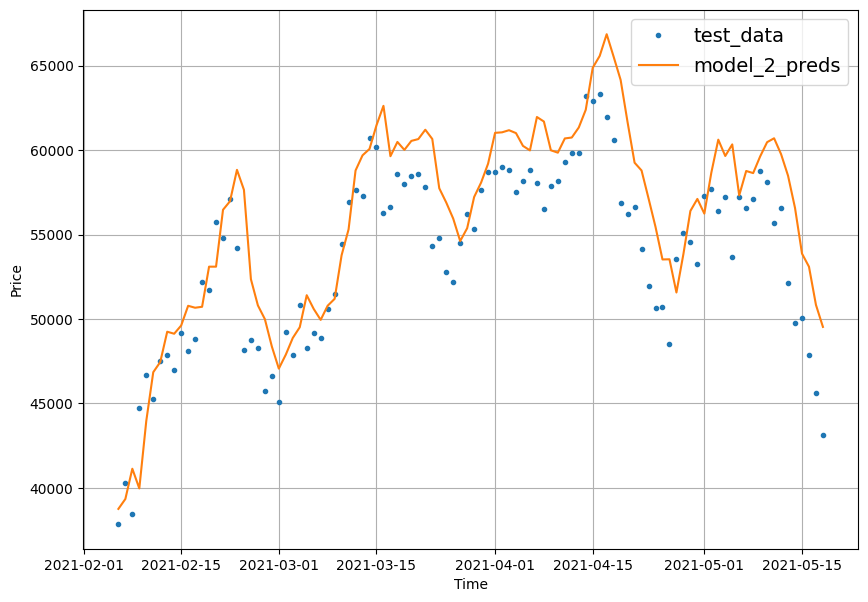

In [90]:
offset = 450
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels,
                 start=offset,
                 label='test_data')
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format='-',
                 label='model_2_preds')

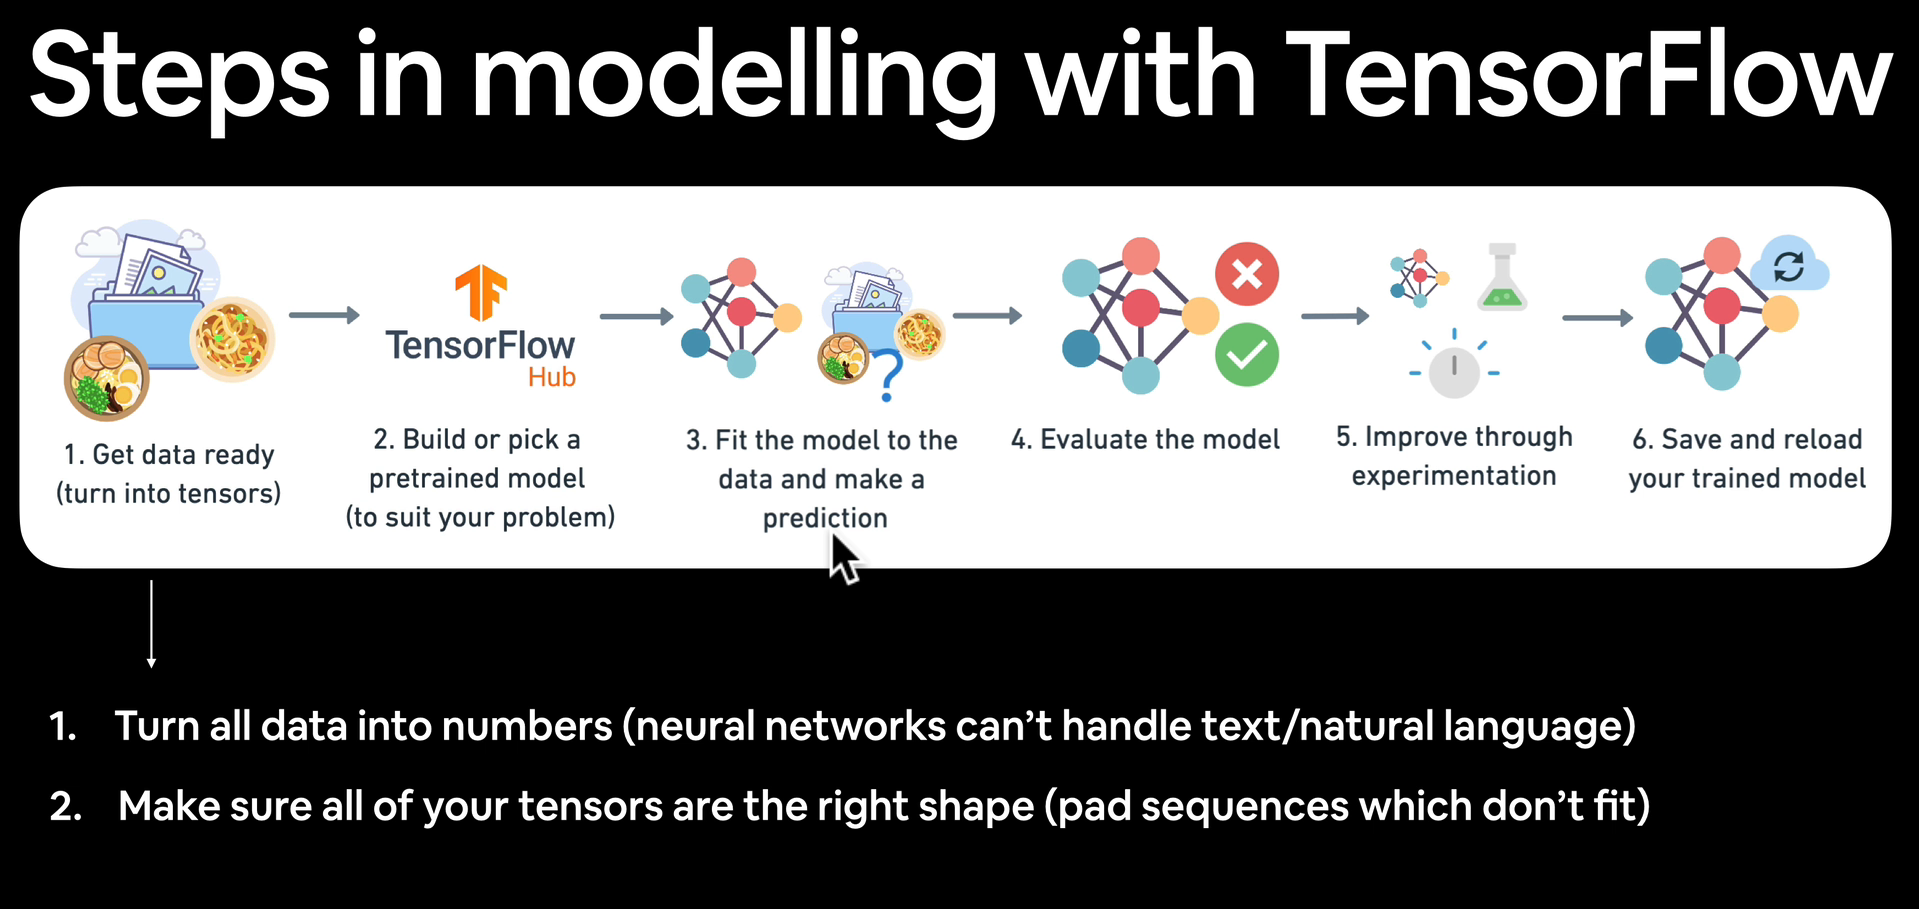

## Model 3: Dense Model (window size = 30, horizon = 7)

In [91]:
# create windowed data of size 30 with horizon 7
HORIZON = 7
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(prices,
                                         horizon=HORIZON,
                                         window_size=WINDOW_SIZE)

Window indices: 
(array([[   0,    1,    2, ...,   34,   35,   36],
       [   1,    2,    3, ...,   35,   36,   37],
       [   2,    3,    4, ...,   36,   37,   38],
       ...,
       [2748, 2749, 2750, ..., 2782, 2783, 2784],
       [2749, 2750, 2751, ..., 2783, 2784, 2785],
       [2750, 2751, 2752, ..., 2784, 2785, 2786]]), (2751, 37))
WIndowed ARray: 
[[  123.65499      125.455        108.58483    ...   210.3075
    225.02         248.25333   ]
 [  125.455        108.58483      118.67466    ...   225.02
    248.25333      262.32666   ]
 [  108.58483      118.67466      121.33866    ...   248.25333
    262.32666      294.48699   ]
 ...
 [58171.9090187  59295.95004401 59822.90167743 ... 49764.1320816
  50032.69313676 47885.62525472]
 [59295.95004401 59822.90167743 59853.19724227 ... 50032.69313676
  47885.62525472 45604.61575361]
 [59822.90167743 59853.19724227 63223.88439079 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [92]:
# Create train test splits with our function
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)

In [93]:
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape

((2200, 30), (2200, 7), (551, 30), (551, 7))

In [101]:
tf.random.set_seed(42)

# Create a functional model
inputs = layers.Input(shape=(WINDOW_SIZE,), name="input_layer")
x = layers.Dense(128, activation="relu")(inputs)
outputs = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_dense")

# Compile the model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit the model
model_3_history = model_3.fit(train_windows,
                              train_labels,
                              epochs=60,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              batch_size=128,
                              callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [106]:
# Evaluate model_3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1268.7750 - mae: 1268.7750 - mse: 5341438.5000


[1268.7750244140625, 1268.7750244140625, 5341438.5]

In [102]:
# Get the forecast predictions
model_3_preds = make_preds(model_3, test_windows)

18/18 [==============================] - 0s 1ms/step


In [111]:
test_labels[:10]

array([[8794.35864452, 8798.04205463, 9081.18687849, 8711.53433917,
        8760.89271814, 8749.52059102, 8656.97092235],
       [8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
        8749.52059102, 8656.97092235, 8500.64355816],
       [9081.18687849, 8711.53433917, 8760.89271814, 8749.52059102,
        8656.97092235, 8500.64355816, 8469.2608989 ],
       [8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 , 8537.33965197],
       [8760.89271814, 8749.52059102, 8656.97092235, 8500.64355816,
        8469.2608989 , 8537.33965197, 8205.80636599],
       [8749.52059102, 8656.97092235, 8500.64355816, 8469.2608989 ,
        8537.33965197, 8205.80636599, 8118.4885358 ],
       [8656.97092235, 8500.64355816, 8469.2608989 , 8537.33965197,
        8205.80636599, 8118.4885358 , 8074.84317361],
       [8500.64355816, 8469.2608989 , 8537.33965197, 8205.80636599,
        8118.4885358 , 8074.84317361, 7612.7405735 ],
       [8469.2608989 , 8

In [112]:
model_3_preds.numpy()[:10]

array([[8979.771 , 9140.442 , 9443.274 , 9379.069 , 9483.204 , 9501.391 ,
        9562.476 ],
       [8683.544 , 8890.675 , 8960.33  , 9232.032 , 9175.446 , 9156.592 ,
        9131.6045],
       [8397.815 , 8881.898 , 8656.633 , 8950.4795, 9007.166 , 8955.159 ,
        8769.581 ],
       [8561.963 , 8926.101 , 8795.72  , 9084.766 , 9184.368 , 9239.824 ,
        8931.728 ],
       [8539.657 , 8739.578 , 8882.049 , 9158.534 , 9142.826 , 9048.934 ,
        8784.175 ],
       [8658.265 , 8700.106 , 8876.051 , 8971.953 , 9178.31  , 8953.297 ,
        8916.602 ],
       [8609.666 , 8686.05  , 8815.66  , 8778.517 , 9169.532 , 8725.095 ,
        8944.073 ],
       [8357.8125, 8653.448 , 8747.691 , 8800.191 , 8939.994 , 8631.941 ,
        8712.979 ],
       [8193.439 , 8744.94  , 8503.342 , 8655.013 , 8866.688 , 8640.473 ,
        8628.544 ],
       [8180.1196, 8469.09  , 8325.58  , 8616.82  , 8738.938 , 8699.524 ,
        8552.427 ]], dtype=float32)

In [115]:
np.squeeze(test_labels).shape, model_3_preds.numpy().shape

((551, 7), (551, 7))

In [120]:
# Evaluate results for model 2 predictions
model_3_results = reg_metrics(y_true=np.squeeze(test_labels),
                             y_pred=model_3_preds.numpy())
model_3_results

{'Mean Absolute Error': 1268.775,
 'Mean Squared Error': 5341438.5,
 'Root Mean Squared Error': 1444.6733,
 'Mean Absolute Percentage Error': 5.7775936,
 'Mean Absolute Scaled Error': 2.2577141422510203}

In [107]:
# Let's load the saved model and evaluate the mdoel
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1240.0504 - mae: 1240.0504 - mse: 5395266.5000


[1240.0504150390625, 1240.0504150390625, 5395266.5]

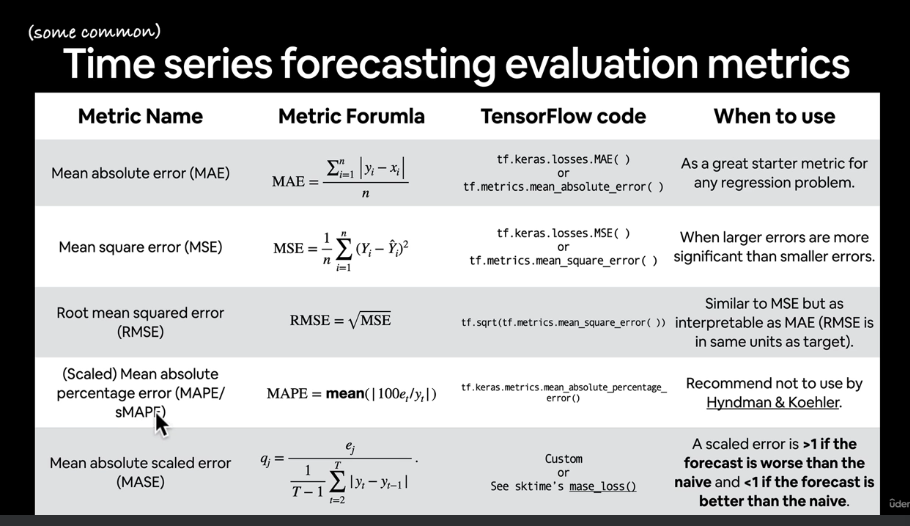